In [1]:
#### Global Variables

#SEIR Model with Social Distancing { run: "auto" }
# Reproduction number
R0 = 2.4

# Disease periods in days
t_incubation = 5.1
t_infective = 3.3 

#Population Size
N = 14000
#Initial number exposed
n = 10 
# Start of social distancing following exposure (weeks)
t_social_distancing = 2
# Effectiveness of social distancing (0 to 100%)
u_social_distancing = 40 

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
# initial number of infected and recovered individuals

e_initial = n/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

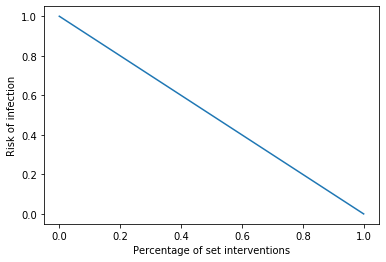

In [4]:
# linear risk of infection, sigma, of strategie,

def sigma_lin(c):
    return 1-c

c = np.linspace(0,1,3001)

plt.plot(c, sigma_lin(c))
plt.xlabel('Percentage of set interventions')
plt.ylabel('Risk of infection')
plt.show()

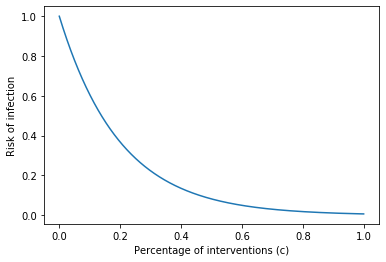

In [5]:
# exponential risk of infection, sigma, of strategie,

def sigma_exp(c):
    return math.e**(-5*c)

c = np.linspace(0,1,3001)

plt.plot(c, sigma_exp(c))
plt.xlabel('Percentage of interventions (c)')
plt.ylabel('Risk of infection')
plt.show()

In [6]:
def sigma(risk_of_infection,t):
    return risk_of_infection if t >= 7*t_social_distancing else 1

In [7]:
# SEIR model differential equations.
def deriv(x, t, u, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -sigma(sigma_lin(u/100),t)*beta * s * i
    dedt =  sigma(sigma_lin(u/100),t)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

In [8]:
#the strategie is set when the number of infections exceed infections_max

def determine_strategie(i, u, u_social_distancing, infections_max, t):
    if (i*N >= infections_max):
        print('set interventions at level',u_social_distancing, 'i*N:',i*N, 't =',t)
        return u_social_distancing
    else: 
        return u

In [9]:
# SEIR model differential equations.
def deriv_flex(x, t, u, u_social_distancing, infections_max, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -sigma(sigma_lin( determine_strategie(i, u, u_social_distancing, infections_max, t)/100),t)*beta * s * i
    dedt =  sigma(sigma_lin( determine_strategie(i, u, u_social_distancing, infections_max, t)/100),t)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt = gamma * i
    return [dsdt, dedt, didt, drdt]

In [10]:
# A grid of time points (in days)
t_max = 365 # maximum number of days, e.g. until vaccination 
t = np.linspace(0, t_max, t_max+1)

x_initial = s_initial, e_initial, i_initial, r_initial
s, e, i, r = odeint(deriv, x_initial, t, args=(u_social_distancing, alpha, beta, gamma)).T
s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T

x_initial_flex = s_initial, e_initial, i_initial, r_initial
infections_max = 500
s_f, e_f, i_f, r_f = odeint(deriv_flex, x_initial_flex, t, args=(0, u_social_distancing, 500, alpha, beta, gamma)).T

TypeError: determine_strategie() missing 1 required positional argument: 't'

In [ ]:
# plot the data
fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(311, axisbelow=True)]

pal = sns.color_palette()

ax[0].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
ax[0].stackplot(t/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
ax[0].stackplot(t/7, N*i_f, N*e_f, colors=pal[2:0:-1], alpha=0.5)
ax[0].set_title('Infected Population with no Social Distancing and with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
ax[0].set_xlim(0, t[-1]/7)
ax[0].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[0].set_xlabel('Weeks following Initial Campus Exposure')
ax[0].legend([
    'Infective/Symptomatic', 
    'Exposed/Not Sympotomatic'],
    loc='upper right')
ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

y0 = N*(e0 + i0)
k0 = np.argmax(y0)
ax[0].annotate("No social distancing", (t[k0]/7, y0[k0] + 100))

y = N*(e + i)
k = np.argmax(y)
ax[0].annotate("With {0:3.0f}% effective social distancing ".format(u_social_distancing), (t[k]/7, y[k] + 100))

y_f = N*(e_f + i_f)
k_f = np.argmax(y_f)
ax[0].annotate("With {0:3.0f}% effective social distancing set at {1} infections".format(u_social_distancing,infections_max), (t[k_f]/7, y_f[k_f] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()